# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [203]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [204]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:** 
     What is the objective of this project in business terms?


**1.2:**  How will your solution be used?



**1.3:**  How should success (or failure) be measured?


    The business objective is to predict the target (tax dollar amount) given the 55 features contained in the original dataset, find out which of those features is most relevant to predicting the target, and eventually 
use that feature or combination of features to make a prediction and give insight to the marketing department. The marketing team may then use that insight to make more targeted advertisements. For example, if we discover that
the amount of square feet and location has a higher impact on the value of a home (as indicated through our target variable of tax dollar amount), then the team may advertise to a limited demographic who they believe would be most likely to make an offer on that particular house. On the data science side, success will be measured by using various metrics to confirm the accuracy of our models before making predictions, using such metrics as mean squared error, mean root squared error, F1 square, Accuracy and Recall as necessary. Success on the marketing side will depend on our findings, and be measured by the amount of marketing efforts that result in successful purchases with the least amount of time on the market.

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [206]:
df.nunique()

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                      1
heatingorsystemtypeid              10
latitude                        64038
longitude                       62461
lotsizesquar

In [207]:
df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


In [208]:
df.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,assessmentyear,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
count,7.761300e+04,25007.000000,207.000000,50.000000,77579.000000,77579.000000,15.000000,49809.000000,76963.000000,614.0,...,223.000000,50703.000000,2393.000000,70.000000,77309.000000,17599.000000,77579.0,2900.000000,7.733200e+04,7.757800e+04
mean,1.300781e+07,1.812013,7.386473,679.720000,2.298496,3.053223,3.933333,6.533779,2.316392,66.0,...,6.040359,1.110309,305.460928,216.385714,1968.611507,1.434286,2016.0,14.088276,6.049667e+13,4.901506e+05
std,3.518717e+06,2.965768,2.728030,689.703546,0.996732,1.140480,0.258199,1.722062,0.979689,0.0,...,0.556035,1.169967,238.735241,190.177514,23.793171,0.544515,0.0,2.181281,1.533339e+12,6.537979e+05
min,1.071186e+07,1.000000,2.000000,38.000000,0.000000,0.000000,3.000000,1.000000,1.000000,66.0,...,4.000000,1.000000,11.000000,12.000000,1824.000000,1.000000,2016.0,3.000000,6.037101e+13,1.000000e+03
25%,1.153821e+07,1.000000,7.000000,273.000000,2.000000,2.000000,4.000000,6.000000,2.000000,66.0,...,6.000000,1.000000,170.000000,61.500000,1953.000000,1.000000,2016.0,14.000000,6.037311e+13,2.068985e+05
50%,1.253004e+07,1.000000,7.000000,515.000000,2.000000,3.000000,4.000000,6.000000,2.000000,66.0,...,6.000000,1.000000,250.000000,164.500000,1970.000000,1.000000,2016.0,15.000000,6.037603e+13,3.588785e+05
75%,1.421101e+07,1.000000,7.000000,796.500000,3.000000,4.000000,4.000000,8.000000,3.000000,66.0,...,6.000000,1.000000,364.000000,310.500000,1987.000000,2.000000,2016.0,15.000000,6.059042e+13,5.690000e+05
max,1.676893e+08,13.000000,21.000000,3560.000000,18.000000,16.000000,4.000000,12.000000,18.000000,66.0,...,13.000000,237.000000,3191.000000,868.000000,2016.000000,6.000000,2016.0,99.000000,4.830301e+14,4.906124e+07


In [209]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 non-null  float64
 12  finishedsquarefeet12          73923 non-null  float64
 13  f

In [210]:

def show_null_counts_features(df):
    # Count the nulls and calculate the %
    count_nulls = df.isnull().sum()
    df_nulls = (df.isnull().mean() * 100).round(2)
    
    # Determine if the column is numeric or non-numeric
    feature_types = df.dtypes.apply(lambda x: 'Numeric' if np.issubdtype(x, np.number) else 'Categorical')
    
    # Filter out the columns with missing values and sort them in descending order
    missing_data = pd.DataFrame({
        'Feature': count_nulls[count_nulls > 0].index,
        '# Null Values': count_nulls[count_nulls > 0].values, 
        'Null %': df_nulls[df_nulls > 0].values,
        'Type': feature_types[count_nulls > 0].values
    }).sort_values(by='Null %', ascending=False)
    
    print(f'The dataset contains {len(df)} samples.\n')

    if (len(missing_data) == 0):
        print("There are no null values in the dataset!")
    else:
        # Print null value stats
        print('Feature Name    # Nulls      Null %    Type')
        print('------------    -------      ------    ----')
        for index, row in missing_data.iterrows():
            print(f"{row['Feature']:<15} {row['# Null Values']:<12} {row['Null %']:.2f}%   {row['Type']}")


# Uncomment to see results
            
show_null_counts_features(df)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
buildingclasstypeid 77598        99.98%   Numeric
finishedsquarefeet13 77571        99.95%   Numeric
basementsqft    77563        99.94%   Numeric
storytypeid     77563        99.94%   Numeric
yardbuildingsqft26 77543        99.91%   Numeric
fireplaceflag   77441        99.78%   Categorical
architecturalstyletypeid 77406        99.73%   Numeric
typeconstructiontypeid 77390        99.71%   Numeric
finishedsquarefeet6 77227        99.50%   Numeric
pooltypeid10    77148        99.40%   Numeric
decktypeid      76999        99.21%   Numeric
poolsizesum     76744        98.88%   Numeric
pooltypeid2     76539        98.62%   Numeric
hashottuborspa  76074        98.02%   Categorical
yardbuildingsqft17 75220        96.92%   Numeric
taxdelinquencyflag 74713        96.26%   Categorical
taxdelinquencyyear 74713        96.26%   Numeric
finishedsquarefeet15 74586        96.10%

#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?
These two features are categorical: propertycountylandusecode, and propertyzoningdesc


**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

These features appear to be useless, or almost completely useless for the purpose of this project: Parcelid is a number that appears to be random, so it will not help us in any predictions. 

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

These features all contained more than 60% null data, so we decided to drop them as we felt that trying to. airconditioningtypeid, architecturalstyletypeid, basementsqft, buildingclasstypeid, finishedfloor1squarefeet,
       finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, finishedsquarefeet6, fireplacecnt, garagecarcnt, garagetotalsqft, hashottuborspa, poolsizesum,
       threequarterbathnbr, typeconstructiontypeid, yardbuildingsqft17, yardbuildingsqft26, numberofstories, fireplaceflag, taxdelinquencyflag, and taxdelinquencyyear

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 
These features: decktypeid, poolcnt, pooltypeid10, pooltypeid2, pooltypeid7, regionidzip, storytypeid, unitcnt, lattitude, longitude, assessmentyear, and censustractandblock;
we ultimately decided to remove because they showed only 1 value populated. That will not help us to make any useful predictions.

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

<Figure size 3000x6000 with 0 Axes>

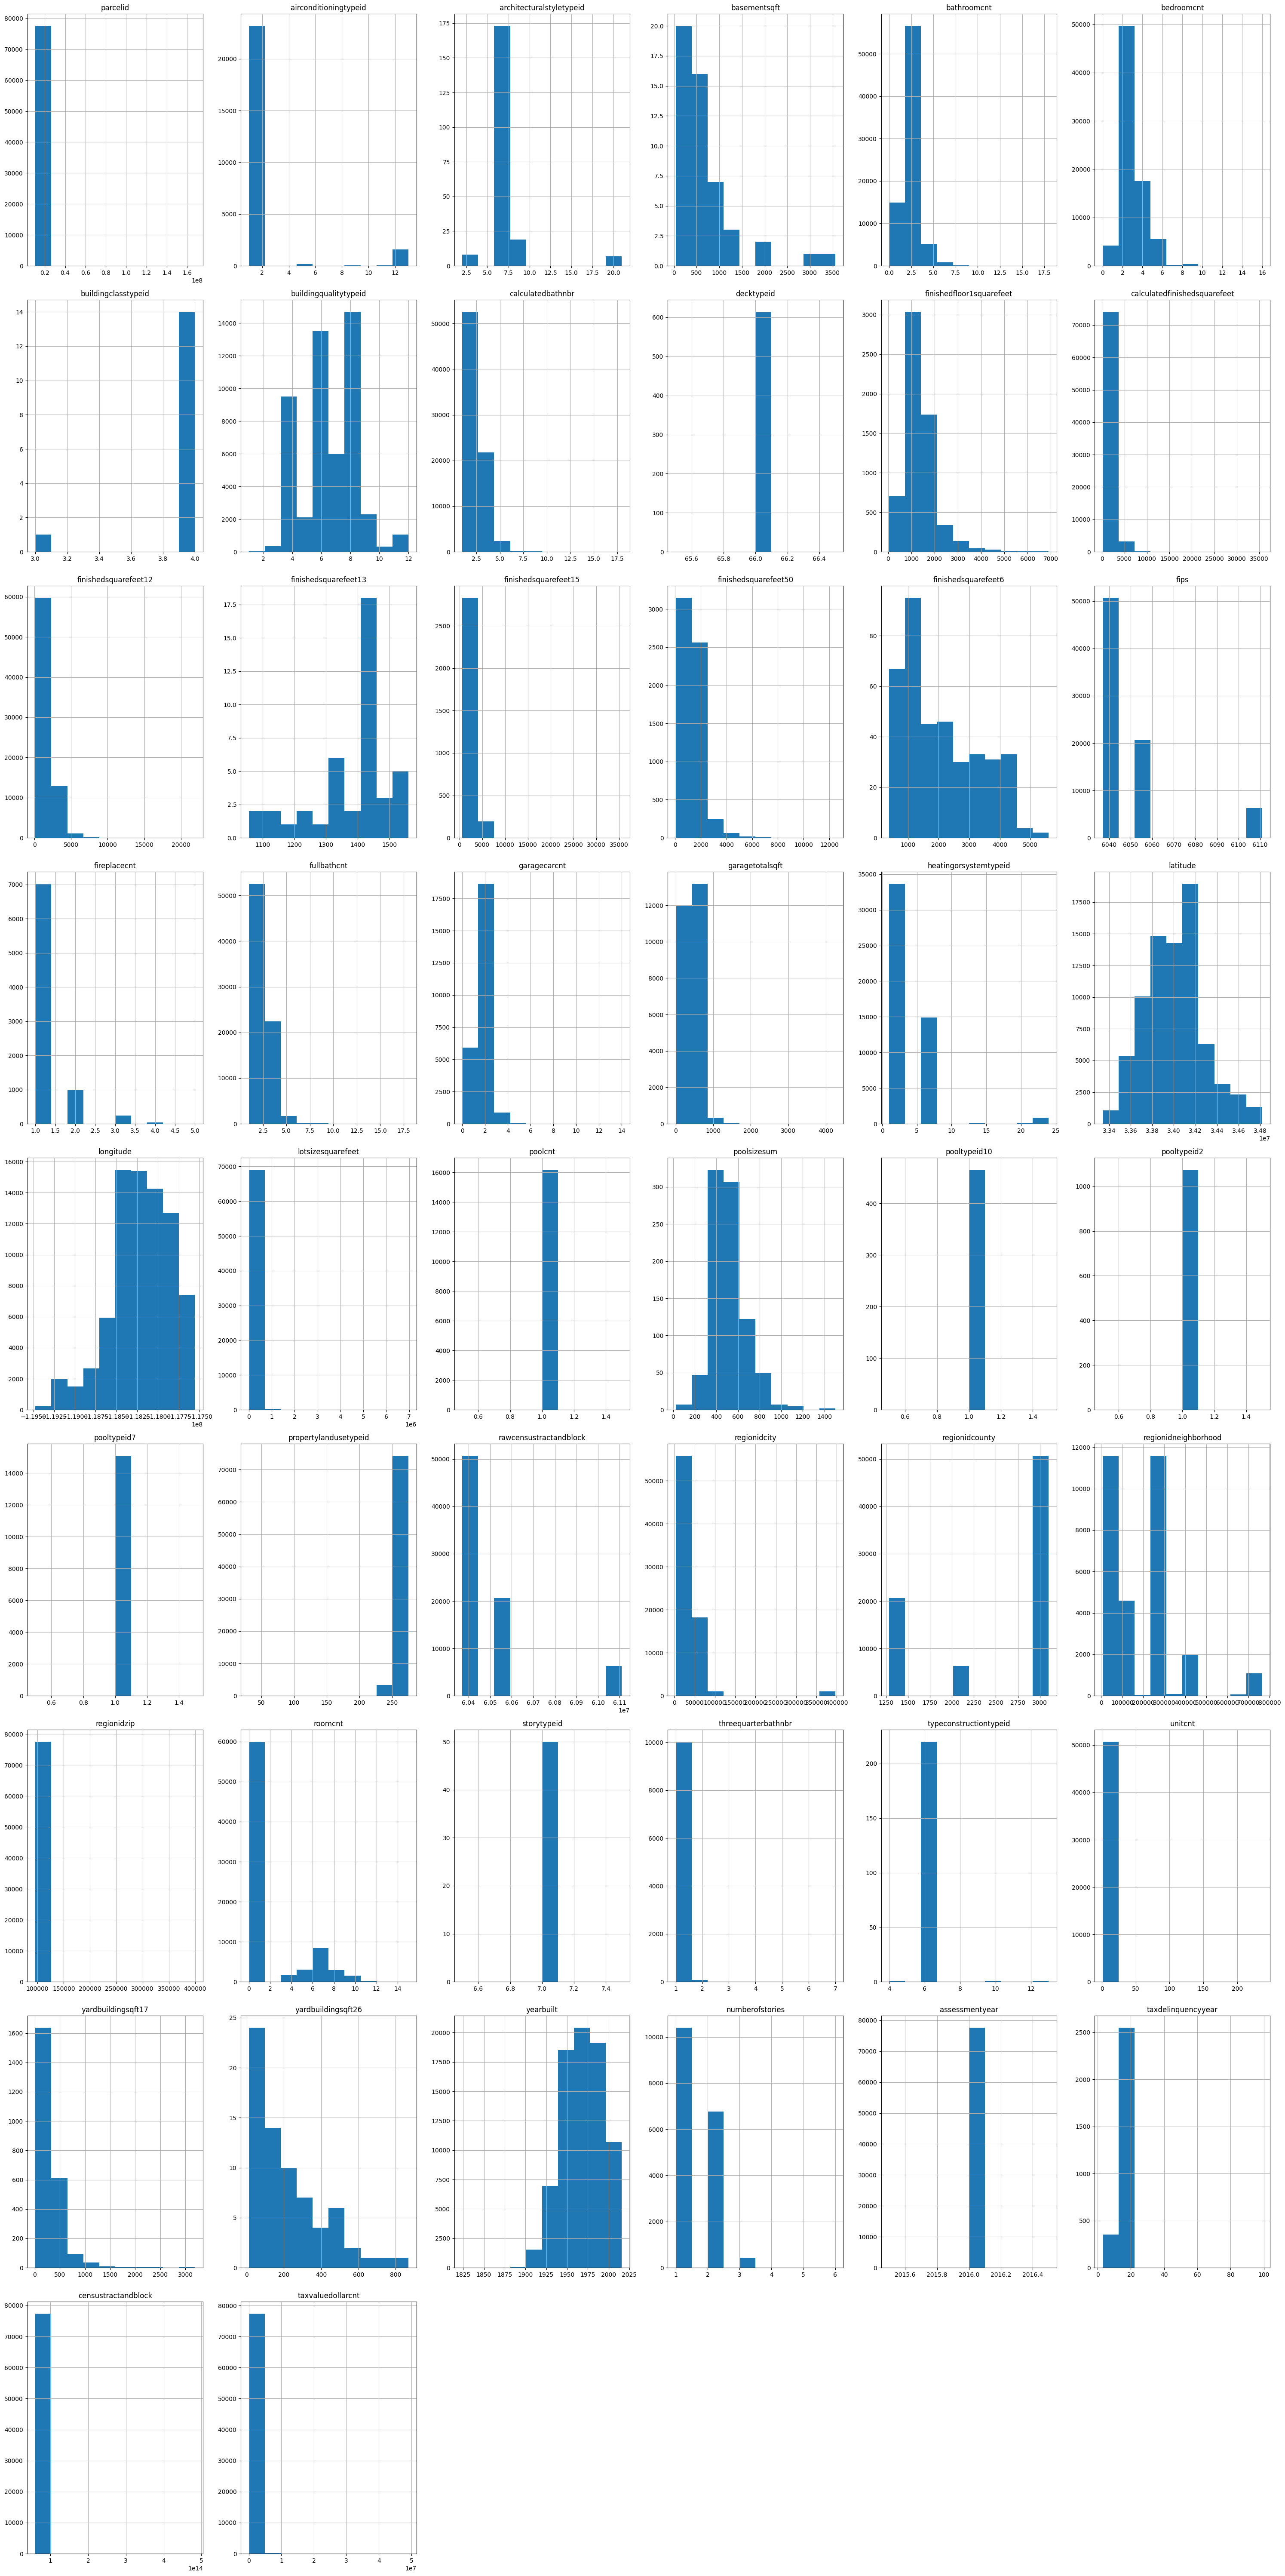

In [211]:
plt.figure(figsize = (30, 60))
df.hist(bins = 10, figsize = (30, 60), layout = (-1, 6))
plt.tight_layout()
plt.show()

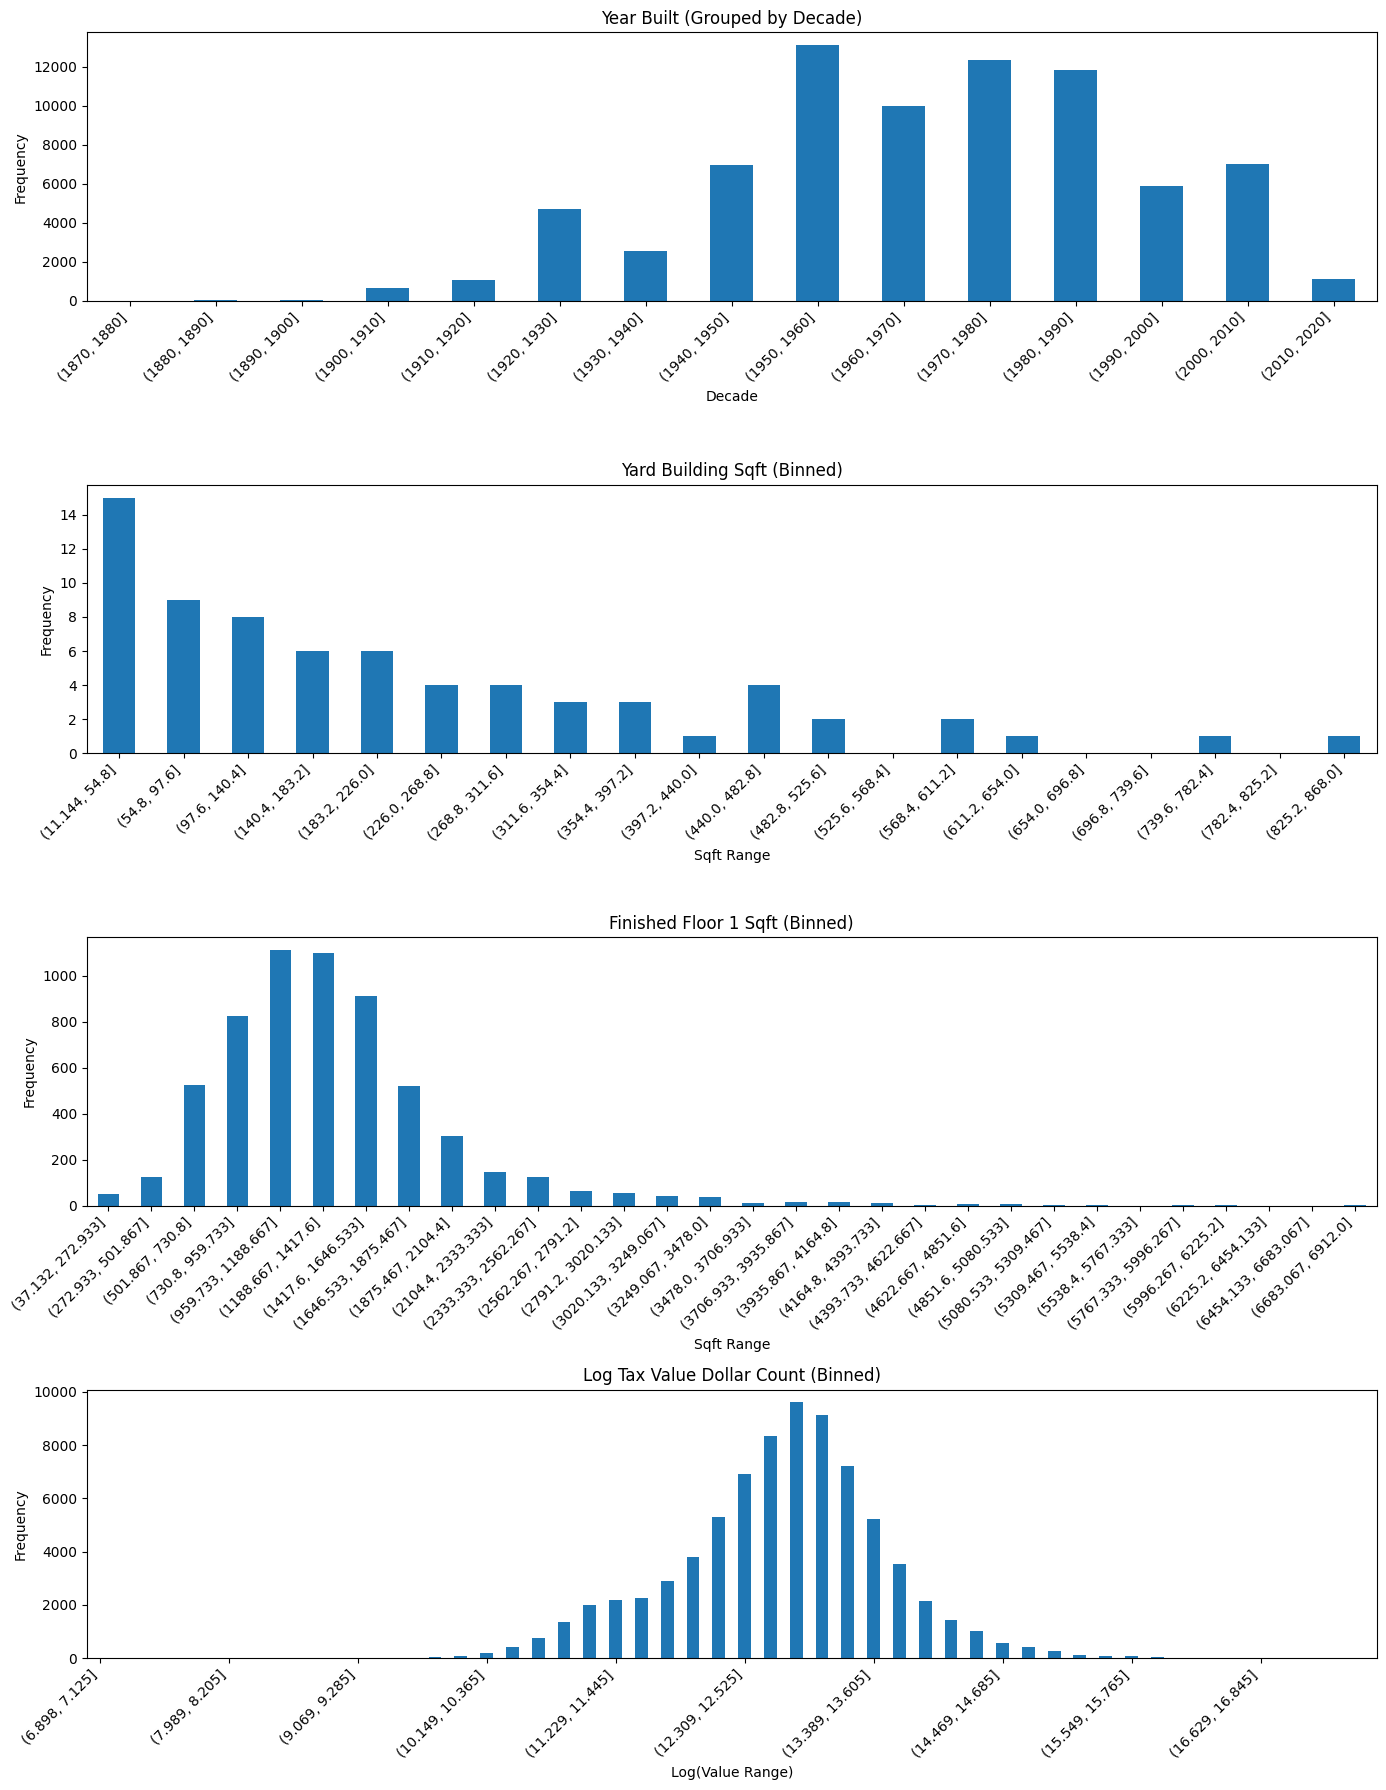

In [212]:
yearbuilt = df["yearbuilt"].value_counts()
yardbuildingsqft26 = df["yardbuildingsqft26"].value_counts()
finishedfloor1squarefeet = df["finishedfloor1squarefeet"].value_counts()
taxvaluedollarcnt = df["taxvaluedollarcnt"].value_counts()

plt.figure(figsize=(14, 18))

year_bins = pd.cut(df["yearbuilt"], bins=range(1870, 2021, 10))  # every 10 years
year_counts = year_bins.value_counts().sort_index()

plt.subplot(4, 1, 1)
year_counts.plot(kind="bar")
plt.title("Year Built (Grouped by Decade)")
plt.xlabel("Decade")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')

# 2. Grouped Yard Building Sqft
yard_bins = pd.cut(df["yardbuildingsqft26"], bins=20)  # adjust bin count as needed
yard_counts = yard_bins.value_counts().sort_index()

plt.subplot(4, 1, 2)
yard_counts.plot(kind="bar")
plt.title("Yard Building Sqft (Binned)")
plt.xlabel("Sqft Range")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')


floor_bins = pd.cut(df["finishedfloor1squarefeet"], bins=30)  # Adjust bins as needed
floor_counts = floor_bins.value_counts().sort_index()

plt.subplot(4, 1, 3)
floor_counts.plot(kind="bar")
plt.title("Finished Floor 1 Sqft (Binned)")
plt.xlabel("Sqft Range")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')

# Apply log transform first
df["log_tax"] = np.log1p(df["taxvaluedollarcnt"])  # log(1 + x) to handle 0s

# Bin log-transformed values
tax_bins = pd.cut(df["log_tax"], bins=50)
tax_counts = tax_bins.value_counts().sort_index()

# Plot
plt.subplot(4, 1, 4)
ax = tax_counts.plot(kind="bar")
plt.title("Log Tax Value Dollar Count (Binned)")
plt.xlabel("Log(Value Range)")
plt.ylabel("Frequency")

# Optional: space out ticks
tick_locs = range(0, len(tax_counts), 5)
tick_labels = [str(tax_counts.index[i]) for i in tick_locs]
plt.xticks(tick_locs, tick_labels, rotation=45, ha="right")


plt.tight_layout()
plt.show()


#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


The Year Built graph is a multimodal, left skewed distribution. It has a few peaks, and the concentration of data is between 1950 and 2010. There are outliers both to the left and right, with more being on the left side. We chose this graph because at first one would think that newer houses automatically would sell for more. We are curious to see if that holds true later on in our analysis. The Yard Building Sqft is right skewed, with a long tail. This indicates that there are very large values among the outliers. Most of the data falls within the 11.144 - 226 range, and that can be incredibly useful when trying to make a prediction our your normal house tax amount vs the outliers. It may help us separate them out to make more accurate predictions later on. The Finished Floor 1 Sqft graph is right skewed, log normal. The mode is somewhere between 1000-1500 sqft, and this graph shows a very long right skewed tail with outliers containing larger sqft. This is an interesting feature that will help us to make predictions excluding outliers based on a normal distribution. The log tax value dollar count graph is a mostly normal distribution. There is a very slight right skew to this graph, but otherwise is looks normal. We originally had the graph displaying raw data, which showed a heavy right skew, but the data was not legible or useable beyond that point, so we ultimately decided to convert it to the log. 

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [213]:
df.drop(columns = ["parcelid", "decktypeid", "poolcnt", "pooltypeid10", "pooltypeid2", "pooltypeid7", "regionidzip", "storytypeid", "unitcnt", "assessmentyear", "censustractandblock"], inplace = True)

#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 

We began by examining the features contained within this dataset, and deciding which were mostly useless, or completely useless to our use case. Parcelid was dropped for instance, because it is completely unique, but doesn't tell us anything in relation to our target variable. The rest of the features we removed mostly contained data with only one value. While this might be useful in other use cases, for our purposes those features were judged to be useless and therefore dropped. 

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [214]:
max_nulls = 50000     

# Count null values per column

count_nulls = df.isnull().sum()

# Filter out columns where null count exceeds max_nulls

filtered_df = count_nulls[count_nulls > max_nulls].index

# Drop the columns

df_clean = df.drop(filtered_df, axis = 1)


# Uncomment to verify they were removed

show_null_counts_features(df_clean)

The dataset contains 77613 samples.

Feature Name    # Nulls      Null %    Type
------------    -------      ------    ----
regionidneighborhood 46639        60.09%   Numeric
heatingorsystemtypeid 28042        36.13%   Numeric
buildingqualitytypeid 27804        35.82%   Numeric
propertyzoningdesc 27137        34.96%   Categorical
lotsizesquarefeet 8292         10.68%   Numeric
finishedsquarefeet12 3690         4.75%   Numeric
regionidcity    1506         1.94%   Numeric
calculatedbathnbr 650          0.84%   Numeric
fullbathcnt     650          0.84%   Numeric
yearbuilt       304          0.39%   Numeric
calculatedfinishedsquarefeet 235          0.30%   Numeric
log_tax         35           0.05%   Numeric
taxvaluedollarcnt 35           0.05%   Numeric
bathroomcnt     34           0.04%   Numeric
bedroomcnt      34           0.04%   Numeric
fips            34           0.04%   Numeric
propertycountylandusecode 34           0.04%   Categorical
latitude        34           0.04%   Numeri

In [215]:
categorical_features = df_clean.select_dtypes(exclude=['number']).columns.tolist()
numeric_features     = df_clean.select_dtypes(include=['number']).columns.tolist()

print(categorical_features)
print(numeric_features)

['propertycountylandusecode', 'propertyzoningdesc']
['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'roomcnt', 'yearbuilt', 'taxvaluedollarcnt', 'log_tax']


In [216]:
dfcleancopy = df_clean.copy()

# Impute categorical columns (using most frequent category)

imputer = SimpleImputer(missing_values = np.nan, strategy= "most_frequent")

# Verify: only numeric features should appear

df_imputed = pd.DataFrame(imputer.fit_transform(dfcleancopy[numeric_features]), columns = numeric_features)

show_null_counts_features(df_imputed)

The dataset contains 77613 samples.

There are no null values in the dataset!


In [217]:
# First make a copy of the cleaned dataset
# df_imputed = df_clean.copy()

# # Impute categorical columns (using most frequent category)
# cat_cols = df_imputed.select_dtypes(include=['category']).columns
# cat_imputer = SimpleImputer(strategy='most_frequent')
# df_imputed[cat_cols] = cat_imputer.fit_transform(df_imputed[cat_cols])
# # Verify: only numeric features should appear
# print(df_clean)
# show_null_counts_features(df_imputed)

In [218]:
# # 1. Separate features and target
X = df_clean.drop("taxvaluedollarcnt", axis=1)
y = df_clean["taxvaluedollarcnt"]



# # 2. Identify categorical columns
# categorical_features = X.select_dtypes(include=['object', 'category']).columns
# numeric_features = X.select_dtypes(include=['number']).columns


# # 3. Impute missing values in categorical columns
# cat_imputer = SimpleImputer(strategy='most_frequent')
# X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])


# num_imputer = SimpleImputer(strategy='median')
# X[numeric_features] = num_imputer.fit_transform(X[numeric_features])




In [219]:
#X.head()

#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped

We began by creating a view that counted null rows per feature and calculated the percentage of nulls against the total. 

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target

We began by 


Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [220]:
# Q1 = y.quantile(0.25)
# Q3 = y.quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Get mask of rows to keep
# inliers = (y >= lower_bound) & (y <= upper_bound)

In [221]:
# X = X[inliers]
# y = y[inliers]

In [222]:
#note to group: We previously saw Standard deviation of over 7. To fix this, we implemented IQR using a split between .25 and .75 to isolate 
# the outliers and drop those rows and drop the outliers.

#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [223]:
# 1. Separate features and target
median_value = df_clean["taxvaluedollarcnt"].median()
X = df_clean.drop("taxvaluedollarcnt", axis=1)
y = df_clean["taxvaluedollarcnt"].fillna(median_value)
#print(y)
print(y.isnull().sum())

# 2. Identify categorical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numeric_features = X.select_dtypes(include=['number']).columns


# 3. Impute missing values in categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = cat_imputer.fit_transform(X[categorical_features])


num_imputer = SimpleImputer(strategy='median')
X[numeric_features] = num_imputer.fit_transform(X[numeric_features])

0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [224]:
# 4. Encode categorical features and put them back safely
enc = OrdinalEncoder()
encoded_array = enc.fit_transform(X[categorical_features])
encoded_df = pd.DataFrame(encoded_array, columns=categorical_features, index=X.index)

# 5. Replace categorical columns with encoded values
X[categorical_features] = encoded_df

# 6. Optionally cast all to float64
X = X.astype('float64')

# 7. Inspect
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bathroomcnt                   77613 non-null  float64
 1   bedroomcnt                    77613 non-null  float64
 2   buildingqualitytypeid         77613 non-null  float64
 3   calculatedbathnbr             77613 non-null  float64
 4   calculatedfinishedsquarefeet  77613 non-null  float64
 5   finishedsquarefeet12          77613 non-null  float64
 6   fips                          77613 non-null  float64
 7   fullbathcnt                   77613 non-null  float64
 8   heatingorsystemtypeid         77613 non-null  float64
 9   latitude                      77613 non-null  float64
 10  longitude                     77613 non-null  float64
 11  lotsizesquarefeet             77613 non-null  float64
 12  propertycountylandusecode     77613 non-null  float64
 13  p

## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

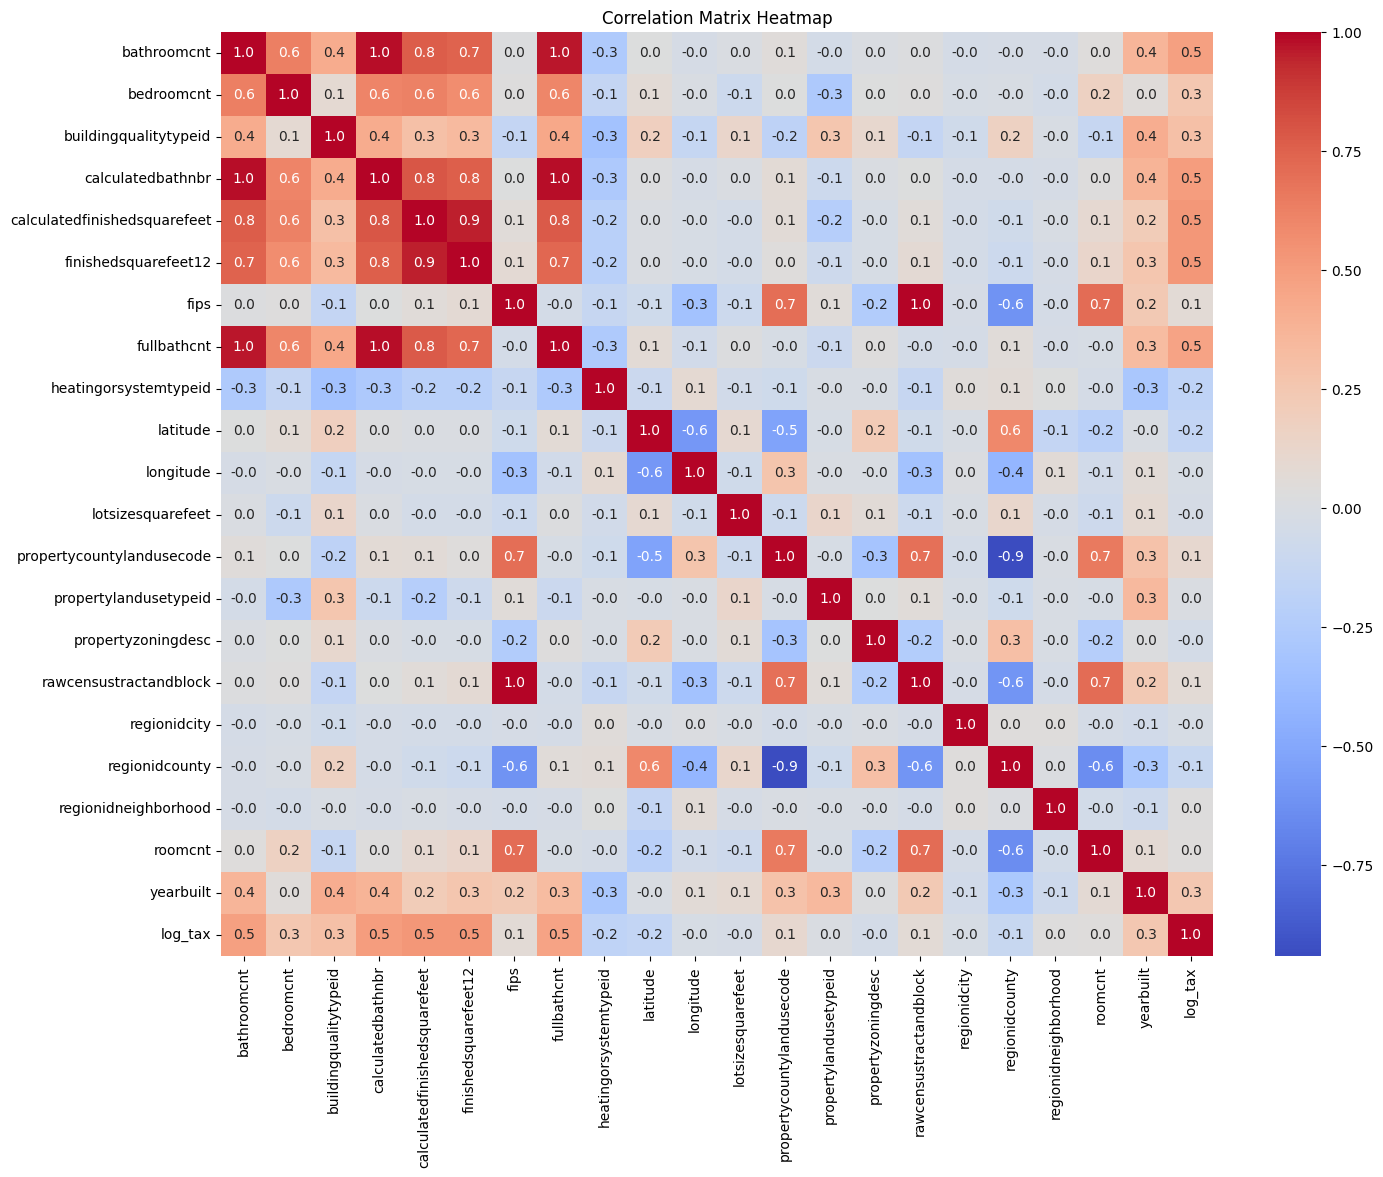

In [225]:
corr_matrix = X.corr()
plt.figure(figsize = (16, 12))
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".1f")
plt.title("Correlation Matrix Heatmap")
plt.show()

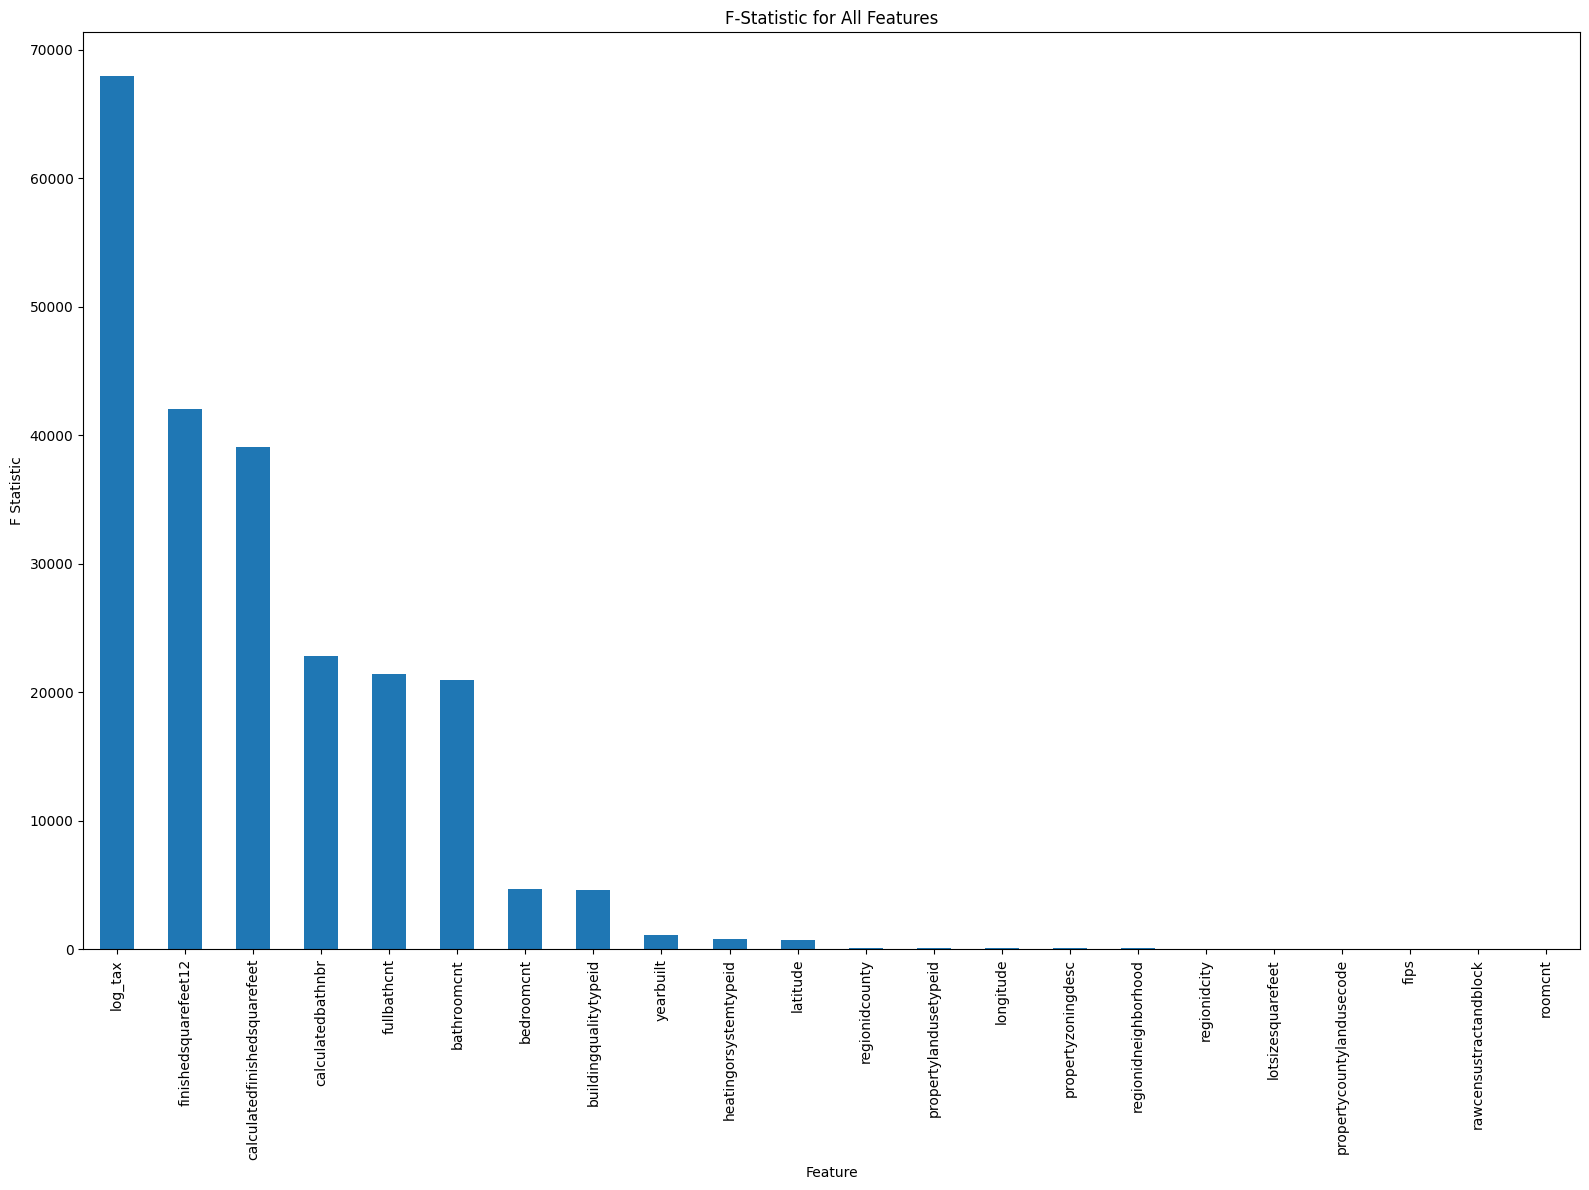

In [226]:
n = len(y)
f_stats = {}

for col in X.columns:
    x = X[col]
    if x.var() == 0:  # Avoid divide-by-zero
        f_stats[col] = np.nan
        continue
    corr = np.corrcoef(x, y)[0, 1]  # Pearson correlation
    f = (corr**2 / (1 - corr**2)) * (n - 2)
    f_stats[col] = f

# Convert to DataFrame and sort
f_df = pd.DataFrame.from_dict(f_stats, orient='index', columns=['F-statistic'])
f_df = f_df.sort_values(by='F-statistic', ascending=False)

f_df  # Show top 10 features

# plt.figure(figsize = (16, 12))
f_df.plot(kind = "bar", figsize = (16, 12), legend = False)
plt.title("F-Statistic for All Features")
plt.xlabel("Feature")
plt.ylabel("F Statistic")
plt.tight_layout()
plt.show()

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)
forward_model = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 42)

In [228]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                              scoring='neg_mean_squared_error', 
                              cv = 5, 
                              tol=None,               # None = no delta cutoff
                                                      # use 0.0 for "no further improvements"
                                                      # and 1e-4 for "point of diminishing returns"                                      
                              max_features=None,      # None = use all features
                              n_jobs=-1,
                              verbose=False
                             ):
    selected_features_forward = []                            # List to store the order of features selected
    remaining_features = list(X.columns)              # Features not yet selected
    best_scores = []                                  # List to store the CV score after each feature addition
    previous_score = float('inf')                     # Initialize previous score for improvement comparison

    # Track the best subset of features and its corresponding score
    
    best_feature_set = None                           # Best combination of features found so far
    best_score_forward = float('inf')                         # Best CV score observed so far
    
    while remaining_features:
        scores = {}                                   # Dictionary to hold CV scores for each candidate feature
        for feature in remaining_features:
            current_features = selected_features_forward + [feature]
            
            # Compute the CV score for the current set of features (negated MSE, so lower is better)
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature_forward = min(scores, key=scores.get)
        current_score = scores[best_feature_forward]
            
        # Check if the improvement is significant based on the tolerance (tol)
        if tol is not None and previous_score - current_score < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list and update score trackers
        selected_features_forward.append(best_feature_forward)
        best_scores.append(current_score)
        remaining_features.remove(best_feature_forward)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features_forward[-3:]}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is better than the best so far
        if current_score < best_score_forward:
            best_score_forward = current_score
            best_feature_set = selected_features_forward.copy()
        
        # Check if the maximum number of features has been reached
        if max_features is not None and len(selected_features_forward) >= max_features:
            break

    return (
        selected_features_forward,      # List of features in the order they were selected (this will be ALL features if max_features == None
        best_scores,            # List of cross-validation scores corresponding to each addition in the previous list
        best_feature_set,       # The subset of features that achieved the best CV score.
        best_score_forward              # The best CV score
    )


In [ ]:
# Your code here:  Run Forward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV Score found. 

# Run Forward Feature Selection


selected_features_forward, best_scores_forward, best_forward_features, best_score_forward =    (
            forward_feature_selection(X, y, forward_model, verbose=True) )

# Plot the results

# index = np.argmax(np.array(selected_features) == best_forward_features[-1])
index = len(best_forward_features)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores_forward) + 1), best_scores_forward, marker='.')
plt.plot([index], [best_score_forward], marker='x', color='red')  # Mark the best score
plt.xticks(range(1, len(selected_features_forward) + 1), selected_features_forward, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print(f"Best Features: {best_forward_features}")
print(f"Best CV Score: {best_score_forward:.4f}")

# Testing

# Filter X_train and X_test to include only the selected features

X_train_best = X_train[best_forward_features]
X_test_best = X_test[best_forward_features]

# Run the test set through the model
# model = RandomForestRegressor()
forward_model.fit(X_train_best, y_train)

y_pred = forward_model.predict(X_test_best)

test_mse = np.sqrt(mean_squared_error(y_test, y_pred))


Features: ['log_tax'], CV Score (MSE): 7790917978.5269

Features: ['log_tax', 'roomcnt'], CV Score (MSE): 7791044012.5628

Features: ['log_tax', 'roomcnt', 'heatingorsystemtypeid'], CV Score (MSE): 7791221036.9508


In [ ]:
backward_model = RandomForestRegressor(n_estimators = 50, n_jobs = -1, random_state = 42)

In [ ]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv = 5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=True
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return -cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score_backward        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set_backward  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features_backward = ['NONE']                     # List to record the order in which features are removed
    best_scores_backward       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if lowest_score < best_score_backward:
            best_score_backward = lowest_score
            best_feature_set_backward = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features_backward.append(feature_to_remove)
        best_scores_backward.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE) {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features_backward,      # Order in which features were removed
        best_scores_backward,            # CV scores after each removal step
        best_feature_set_backward,       # Feature set that achieved the best CV score
        best_score_backward              # Best (lowest) CV score
    )


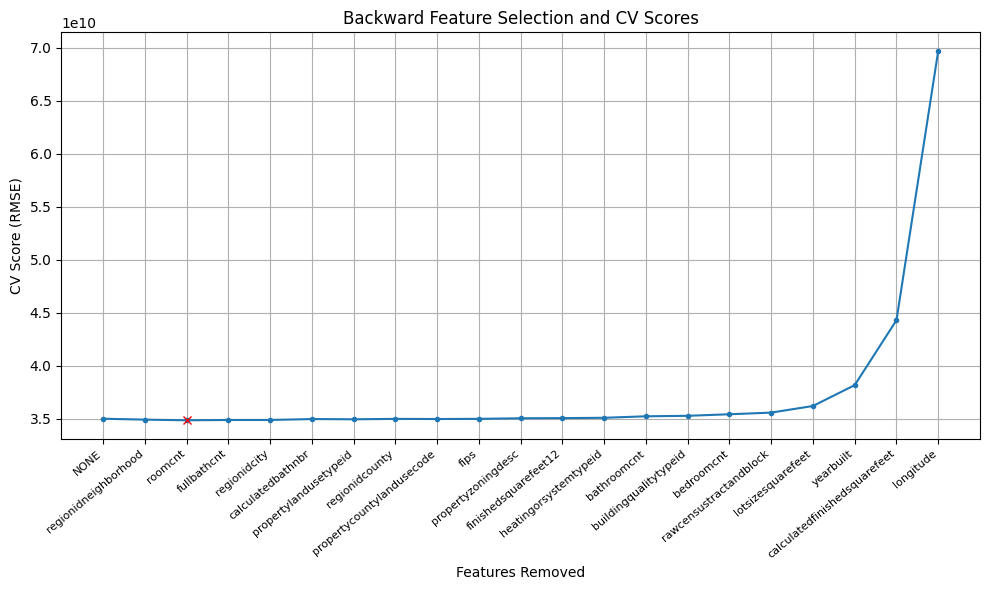

Best feature set: ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'yearbuilt']
CV score (MSE): 34851210206.6289


In [ ]:
# Your code here:  Run Backward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV RMSE Score found. 

# run backward selection and display results


selected_features_backward, best_scores_backward, best_feature_set_backward, best_score_backward = (
    backward_feature_selection(X_train, y_train, backward_model, verbose=False)                             
)

plt.figure(figsize=(10, 6))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(1, len(best_scores_backward) + 1), best_scores_backward, marker='.')
index = np.argmin(best_scores_backward) 
plt.plot([index + 1], best_scores_backward[index], marker='x', color='red')  
plt.xticks(range(1, len(selected_features_backward) + 1), selected_features_backward, rotation=40, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel('CV Score (RMSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print minimum cv score

print("Best feature set:", best_feature_set_backward)
print("CV score (MSE):",np.around(best_score_backward,4))


# Test

# Filter X_train and X_test to include only the selected features
X_train_best_backward = X_train[best_feature_set_backward]
X_test_best_backward = X_test[best_feature_set_backward]

# Train the LinearRegression model on the selected features

backward_model.fit(X_train_best_backward, y_train)

# Predict on the test set
y_pred = backward_model.predict(X_test_best_backward)

# Calculate the test MSE
backward_test_mse = np.sqrt(mean_squared_error(y_test, y_pred))


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 


   #Bedroom Count vs. Finished Square Feet
    #Noticeable clear upward trend from the figure it seems like homes with more bedrooms almost always have more finished square footage.
    #Increasing variance
    #As you go from 1-8 bedrooms, the spread in sqft grows: 7 and 8 bed homes range anywhere from ~1,500 ft^2 up to 8,000 ft^2
    #Above about 6 bedrooms, each additional bedroom adds less area on average as seen from slope flattens out, but the extreme high‑end still pushes much larger.

#Finished Square Feet vs. Bathroom Number
    #There is positive correlation. More bathrooms tend to come with more living area—fewer baths which cluster below 2,500 ft^2, while 4–6 baths often exceed 3,000 ft^2.
    #Less discrete “steps.” Because bathrooms can include half‑baths or odd counts (1.5, 2.5…), the relationship looks a bit messier than pure bedroom counts, but overall it tracks very closely with size.
    # Wider overlap at mid‑sizes. Between about 2.5–4 baths, homes of 2,000–5,000 ft^2 all intermingle, showing that bathroom count alone doesn’t pinpoint size quite as tightly as bedrooms do.

#Build Quality Type ID vs. Finished Square Feet
    #Generally upward, but noisier. Higher build‑quality skew toward larger homes, but each quality band still spans a wide range of sizes.
    #Discrete bands because quality is an ordinal integer, you see “vertical clouds” of points. Lower IDs (1–3) rarely exceed ~2,000 ft^2, whereas IDs 6–12 regularly hit 4,000–7,000 ft^2.
    #Overlap persists. Even top‑quality homes include some modestly sized properties, so build quality is a weaker predictor of size than bed/bath count.

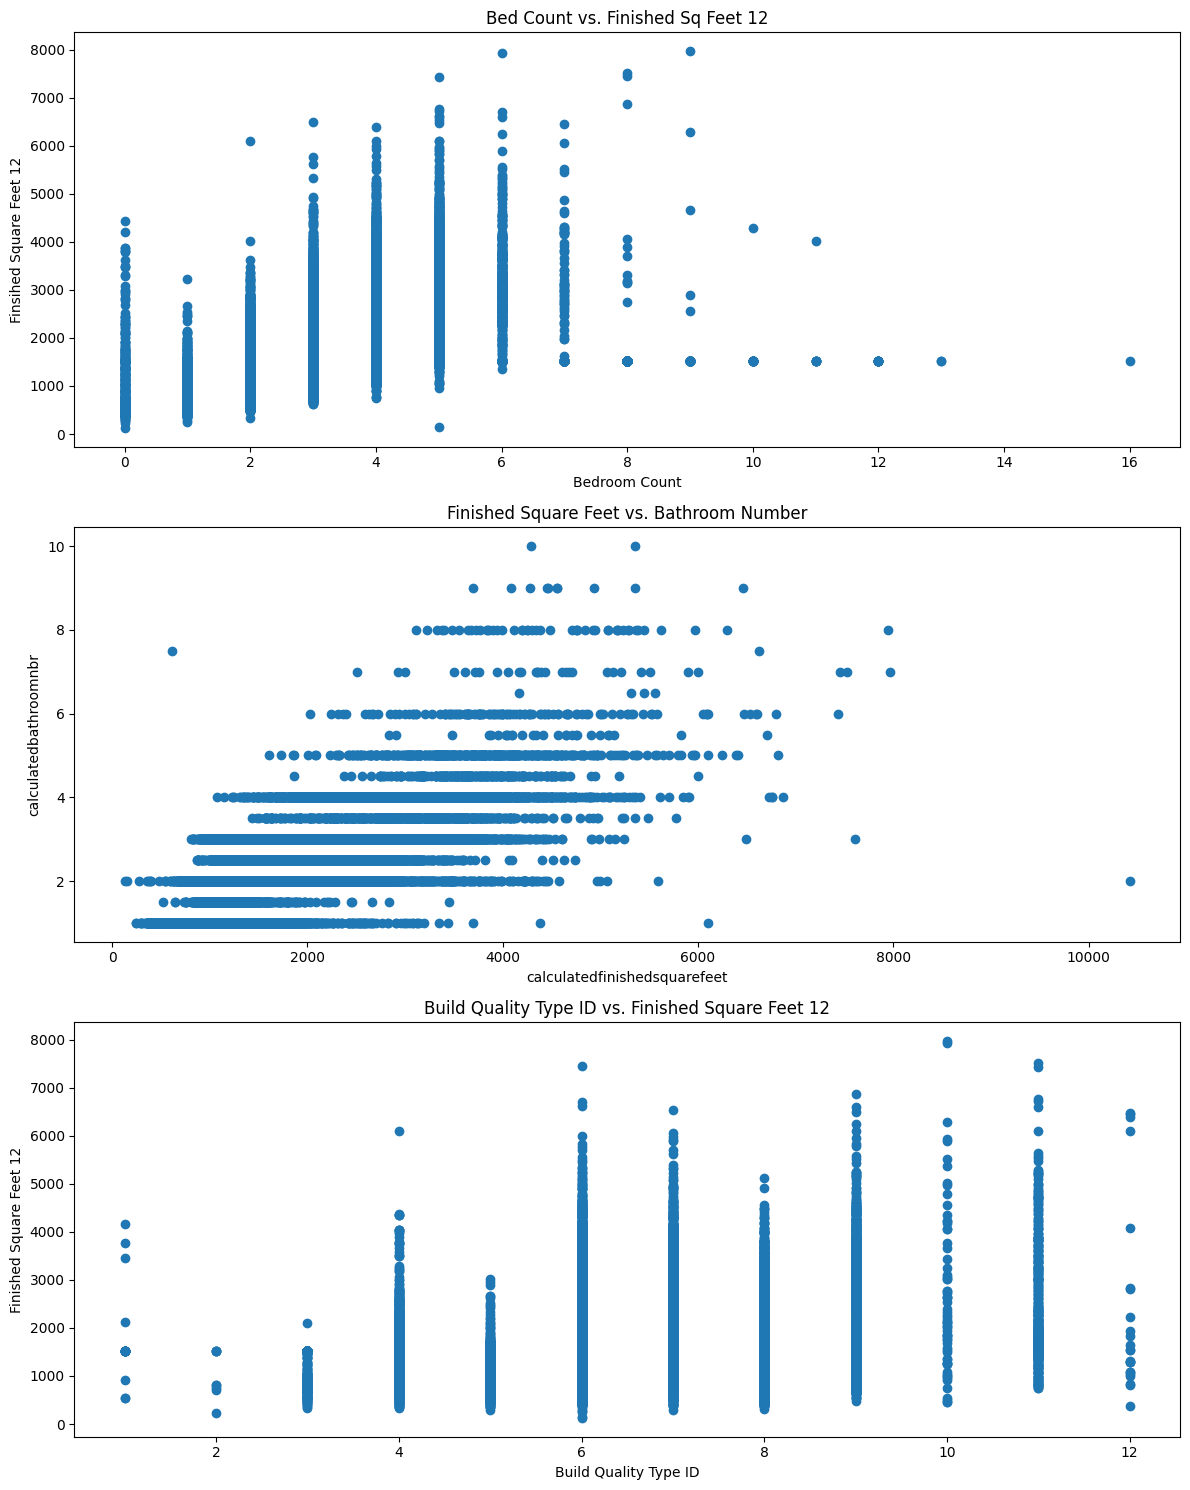

In [ ]:
plt.figure(figsize = (12, 15))
plt.subplot(3, 1, 1)
plt.scatter(X["bedroomcnt"], X["finishedsquarefeet12"])
plt.title("Bed Count vs. Finished Sq Feet 12")
plt.xlabel("Bedroom Count")
plt.ylabel("Finsihed Square Feet 12")

plt.subplot(3, 1, 2)
plt.scatter(X["calculatedfinishedsquarefeet"], X["calculatedbathnbr"])
plt.title("Finished Square Feet vs. Bathroom Number")
plt.xlabel("calculatedfinishedsquarefeet")
plt.ylabel("calculatedbathroomnbr")

plt.subplot(3, 1, 3)
plt.scatter(X["buildingqualitytypeid"], X["finishedsquarefeet12"])
plt.title("Build Quality Type ID vs. Finished Square Feet 12")
plt.xlabel("Build Quality Type ID")
plt.ylabel("Finished Square Feet 12")

plt.tight_layout()
plt.show()

In [ ]:
#Bedroom Count vs. Finished Square Feet
    #Noticeable clear upward trend from the figure it seems like homes with more bedrooms almost always have more finished square footage.

#Increasing variance
    #As you go from 1-8 bedrooms, the spread in sqft grows: 7 and 8 bed homes range anywhere from ~1,500 ft^2 up to 8,000 ft^2

#Above about 6 bedrooms, each additional bedroom adds less area on average as seen from slope flattens out, but the extreme high‑end still pushes much larger.

#Finished Square Feet vs. Bathroom Number
    #There is positive correlation. More bathrooms tend to come with more living area—fewer baths which cluster below 2,500 ft^2, while 4–6 baths often exceed 3,000 ft^2.
    #Less discrete “steps.” Because bathrooms can include half‑baths or odd counts (1.5, 2.5…), the relationship looks a bit messier than pure bedroom counts, but overall it tracks very closely with size.
    # Wider overlap at mid‑sizes. Between about 2.5–4 baths, homes of 2,000–5,000 ft^2 all intermingle, showing that bathroom count alone doesn’t pinpoint size quite as tightly as bedrooms do.

#Build Quality Type ID vs. Finished Square Feet
    #Generally upward, but noisier. Higher build‑quality skew toward larger homes, but each quality band still spans a wide range of sizes.
    #Discrete bands because quality is an ordinal integer, you see “vertical clouds” of points. Lower IDs (1–3) rarely exceed ~2,000 ft^2, whereas IDs 6–12 regularly hit 4,000–7,000 ft^2.
    #Overlap persists. Even top‑quality homes include some modestly sized properties, so build quality is a weaker predictor of size than bed/bath count.

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [ ]:
one_hot = pd.get_dummies(X, columns = ["fullbathcnt", "bedroomcnt"]).astype(int)

In [ ]:
#Standardization
#Load or define your DataFrame
#Select the numeric columns you want to standardized
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
#Initialize the StandardScaler
scaler = StandardScaler()
#Fit the scaler on your numeric data and transform it
df_scaled = X.copy()
df_scaled[numeric_cols] = scaler.fit_transform(X[numeric_cols])
#Check the result
print(df_scaled)

       bathroomcnt  bedroomcnt  buildingqualitytypeid  calculatedbathnbr  \
0         1.519451    0.910911              -0.197606           1.538840   
1        -1.392409   -0.899855              -0.197606          -1.442312   
2        -0.227665    0.005528              -0.197606          -0.249851   
3         0.937079    0.910911               1.308905           0.942609   
4         0.937079    0.005528               1.308905           0.942609   
...            ...         ...                    ...                ...   
77608     0.937079    0.005528               1.308905           0.942609   
77609    -0.227665   -0.899855              -0.197606          -0.249851   
77610    -0.227665    0.910911              -0.197606          -0.249851   
77611    -1.392409    0.005528              -1.704116          -1.442312   
77612    -0.227665    0.005528              -0.197606          -0.249851   

       calculatedfinishedsquarefeet  finishedsquarefeet12      fips  \
0               

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

